In [1]:
%%capture
!pip install xbatcher tensorboard imbalanced-learn

In [2]:
import os
if 'notebooks' in os.getcwd():
    os.chdir("..")

import util
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

# If we have gpu available, use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
torch.set_default_device(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



Prepare data

In [3]:
ds = xr.open_dataset("data_working/westmort.nc")\
    .squeeze(drop=True)\
    .drop_vars("spatial_ref")

In [4]:
# Use EWMA to smooth mortality observations
ds["mort_ewma"] = xr.apply_ufunc(
    util.manip.numpy_ewma_vectorized,
    ds.mortality,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    kwargs=dict(window=3)
)

In [5]:
# Calculate total basal area based on all the genus rasters
ba_vars = ["abies", "picea", "populus", "tsuga", "pseudotsuga"]
ds["forest_ba"] = ds[ba_vars].to_stacked_array("band", sample_dims=["x", "y", "time"]).sum(dim="band")

In [6]:
ds = ds.to_stacked_array("band", sample_dims=["x", "y", "time"])\
    .transpose("time", "band", ...)
ds

<xarray.DataArray 'abies' (time: 27, band: 18, y: 652, x: 590)> Size: 748MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]]], dtype=float32)
Coordinates:
  * time      (time) int64 216B 1997 1998 1999 2000 2001 ... 2020 2021 2022 2023
  * x         (x) float64 5kB -1.389e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y         (y) float64 5kB 6.278e+06 6.274e+06 ... 3.678e+06 3.674e+06
  * band      (band) object 144B MultiIndex
  * variable  (band) <U11 792B 'abies' 'picea' ... 'mort_ewma' 'forest_ba'

Make sure windowing works right

In [7]:
window = dict(x=[8, False], y=[8, False], time=[5, False])
mort_arr = ds.sel(band="mort_ewma", drop=True)
mort_ds = util.datasets.WindowXarrayDataset(ds, window, mask=mort_arr)

print(len(mort_ds))

89226


In [8]:
eg_window = mort_ds[10]
window_x = eg_window.isel(time=slice(None, -1))
window_y = eg_window.isel(time=-1).sel(band="mort_ewma")

In [9]:
assert not np.any(np.isnan(window_y.values))

Set up model definition

In [10]:
ds.band

<xarray.DataArray 'band' (band: 18)> Size: 144B
array([('abies',), ('picea',), ('populus',), ('pseudotsuga',), ('tsuga',),
       ('vod',), ('elev',), ('slope',), ('northness',), ('eastness',),
       ('fire',), ('mortality',), ('prcp',), ('vp',), ('tmin',),
       ('treecover',), ('mort_ewma',), ('forest_ba',)], dtype=object)
Coordinates:
  * band      (band) object 144B MultiIndex
  * variable  (band) <U11 792B 'abies' 'picea' ... 'mort_ewma' 'forest_ba'

In [11]:
from util.convlstm import DamageConvLSTM

input_bands = ["fire", "mort_ewma", "prcp", "elev", "treecover", "forest_ba", "vp", "tmin"]
input_inds = np.where(np.isin(ds.coords.get("variable").values, input_bands))[0]
input_channel = len(input_bands)
hidden_dim = 8
num_layers = 2
kernel = (3, 3)

m = DamageConvLSTM(input_channel, hidden_dim, kernel, num_layers, batch_first=True)

Verify that the shapes work out.

In [12]:
fake_input = torch.tensor(window_x.isel(band=input_inds).values).unsqueeze(0).to(torch.float32)
fake_output = m(fake_input)
assert fake_output.shape == window_y.shape

Data pipeline

In [13]:
# Prepare data laoders. Since we are using a 5-year lookback here, each dataset
# has to be temporally disjoint so we don't leak data. Since 2020 had very few
# surveys we have to ignore it.
years = ds.time.values

train_years = years[16:]
valid_years = years[:8]
test_years = years[8:16]

print("Training years:", train_years)
print("Validation years:", valid_years)
print("Testing years:", test_years)

Training years: [2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]
Validation years: [1997 1998 1999 2000 2001 2002 2003 2004]
Testing years: [2005 2006 2007 2008 2009 2010 2011 2012]


In [14]:
valid_wds = util.datasets.WindowXarrayDataset(
    ds.sel(time=valid_years), window, 
    mask=mort_arr.sel(time=valid_years), 
)
test_wds  = util.datasets.WindowXarrayDataset(
    ds.sel(time=test_years), window, 
    mask=mort_arr.sel(time= test_years), 
)

print("Count of examples")
print("Validation:", len(valid_wds))
print("Testing:", len(test_wds))

Count of examples
Validation: 8361
Testing: 22516


In [15]:
from torch.utils.data import DataLoader

train_target_ind = np.where(ds.coords.get("variable").values == "mort_ewma")[0][0]
valid_target_ind = np.where(ds.coords.get("variable").values == "mortality")[0][0]

dtype = torch.float32
# cutoff = 1

def make_collator(input_inds, target_ind):
    def collator(patch_list):
        X = torch.stack([
            torch.tensor(
                np.squeeze(patch.values[:-1, input_inds, :, :]),
                dtype=dtype
            )
            for patch in patch_list
        ])
    
        # Replace nan cells with the channel mean from this batch
        ch_mean = torch.nanmean(X, dim=0)
        X = torch.nan_to_num(X)
        X += ch_mean * torch.isnan(X)
        
        y = torch.stack([
            torch.tensor(patch.values[-1, target_ind, :, :], dtype=dtype)
            for patch in patch_list
        ]).squeeze(dim=2)/100
    
        return X, y

    return collator

train_collator = make_collator(input_inds, train_target_ind)
valid_collator = make_collator(input_inds, valid_target_ind)

batch_size = 32

# Setting the RNG to host device is necessary if we want to run on GPU
valid_loader = DataLoader(
    valid_wds, 
    batch_size, 
    shuffle=True, 
    collate_fn=valid_collator, 
    generator=torch.Generator(device=device)
)
test_loader  = DataLoader(
    test_wds, 
    batch_size, 
    shuffle=True, 
    collate_fn=valid_collator, 
    generator=torch.Generator(device=device)
)

In [16]:
# Again make sure the sizes work out
X, y = tuple(next(iter(valid_loader)))
print(X.shape)
out = m(X)
print(out.shape)
assert out.shape == y.shape

torch.Size([32, 4, 8, 8, 8])
torch.Size([32, 8, 8])


In [17]:
reload(util.datasets)

<module 'util.datasets' from '/home/jovyan/ForestLST/util/datasets.py'>

In [18]:
cutoffs = np.arange(0.5, 10, step=0.5)
ns = np.zeros(cutoffs.shape)

train_ds = ds.sel(time=train_years)

window_mean = train_ds.isel(band=train_target_ind).rolling(x=8, y=8, time=5).mean()

for i, c in enumerate(cutoffs):
    ns[i] = (window_mean > c).sum().values

In [19]:
reload(util.training)
from util.training import BaseTrainer, ReduceLRMixin, EarlyStopMixin

# Masked loss is very slow for some reason
class Trainer(ReduceLRMixin, EarlyStopMixin, BaseTrainer):
    pass

In [20]:
import torchmetrics
from util.convlstm import DamageConvLSTM

wds = util.datasets.WindowXarrayDataset(
    train_ds, window, mask=mort_arr.sel(time=train_years)
)
print(f"N: {len(wds)}")

train_loader = DataLoader(
    wds, batch_size, 
    shuffle=True, collate_fn=train_collator, 
    generator=torch.Generator(device=device)
)

# Model params
input_channel = len(input_bands)
hidden_dim = 4
num_layers = 2
kernel = (3, 3)
m = DamageConvLSTM(
    input_channel, 
    hidden_dim, 
    kernel, 
    num_layers, 
    batch_first=True,
    dropout=0.3
)

# Init bias
mean_mort = window_mean.mean().values/100
init_bias = np.log(mean_mort / (1 - mean_mort))
torch.nn.init.constant_(m.conv.bias, init_bias)

# Build trainer
loss = torch.nn.MSELoss()
opt  = torch.optim.Adam(m.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3, factor=0.2)
metrics = util.training.get_regr_metrics()

model_name = f"03182025_convlstm__8_8_5__ewma__8band"
logdir = os.path.join("logs", model_name)

# Remove existing logs if present
if os.path.exists(logdir):
    util.training.remove_log(logdir)

trainer = Trainer(
    m, opt, scheduler, loss, train_loader, valid_loader,
    metrics=metrics, 
    n_epochs=30,
    tensorboard_log=os.path.join(logdir, "history"),
    model_log=os.path.join(logdir, "model.pth"),
    defn_log=os.path.join(logdir, "model_definition.txt"),
    verbose=True,
    stop_patience=5,
    rel_improve=0.01
)

trainer.train()

N: 17426


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 1 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train        0.002062
2                               Loss/valid  tensor(0.0052)
3                MeanAbsoluteError()/train     0.018970363
4                MeanAbsoluteError()/valid      0.02051133
5                 MeanSquaredError()/train       0.0020618
6                 MeanSquaredError()/valid     0.005242834
7   NormalizedRootMeanSquaredError()/train       2.1863222
8   NormalizedRootMeanSquaredError()/valid       3.8007448
9                          R2Score()/train      0.46996033
10                         R2Score()/valid      0.18238282



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 2 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train        0.001609
2                               Loss/valid  tensor(0.0053)
3                MeanAbsoluteError()/train      0.01752435
4                MeanAbsoluteError()/valid     0.020894915
5                 MeanSquaredError()/train    0.0016088815
6                 MeanSquaredError()/valid     0.005341036
7   NormalizedRootMeanSquaredError()/train       1.9313132
8   NormalizedRootMeanSquaredError()/valid       3.8361733
9                          R2Score()/train       0.5863948
10                         R2Score()/valid      0.16706795



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 3 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train         0.00152
2                               Loss/valid  tensor(0.0055)
3                MeanAbsoluteError()/train     0.017266694
4                MeanAbsoluteError()/valid      0.02016226
5                 MeanSquaredError()/train    0.0015201647
6                 MeanSquaredError()/valid     0.005502461
7   NormalizedRootMeanSquaredError()/train       1.8773103
8   NormalizedRootMeanSquaredError()/valid        3.893711
9                          R2Score()/train       0.6092019
10                         R2Score()/valid      0.14189345



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 4 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train        0.001498
2                               Loss/valid  tensor(0.0054)
3                MeanAbsoluteError()/train     0.016988022
4                MeanAbsoluteError()/valid     0.019596975
5                 MeanSquaredError()/train    0.0014981992
6                 MeanSquaredError()/valid     0.005393112
7   NormalizedRootMeanSquaredError()/train       1.8636973
8   NormalizedRootMeanSquaredError()/valid        3.854829
9                          R2Score()/train       0.6148486
10                         R2Score()/valid      0.15894705



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 5 of 30
                                       Key           Value
0                             LearningRate           0.001
1                               Loss/train        0.001435
2                               Loss/valid  tensor(0.0054)
3                MeanAbsoluteError()/train     0.016466213
4                MeanAbsoluteError()/valid     0.019305302
5                 MeanSquaredError()/train    0.0014354973
6                 MeanSquaredError()/valid    0.0054498175
7   NormalizedRootMeanSquaredError()/train       1.8242815
8   NormalizedRootMeanSquaredError()/valid       3.8750443
9                          R2Score()/train       0.6309679
10                         R2Score()/valid      0.15010399



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 6 of 30
                                       Key           Value
0                             LearningRate           0.001
1                               Loss/train        0.001373
2                               Loss/valid  tensor(0.0053)
3                MeanAbsoluteError()/train     0.015923865
4                MeanAbsoluteError()/valid     0.019311909
5                 MeanSquaredError()/train    0.0013726101
6                 MeanSquaredError()/valid     0.005274643
7   NormalizedRootMeanSquaredError()/train       1.7838756
8   NormalizedRootMeanSquaredError()/valid       3.8122566
9                          R2Score()/train      0.64713454
10                         R2Score()/valid      0.17742187



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 7 of 30
                                       Key           Value
0                             LearningRate           0.001
1                               Loss/train        0.001363
2                               Loss/valid  tensor(0.0052)
3                MeanAbsoluteError()/train     0.015828777
4                MeanAbsoluteError()/valid     0.019193258
5                 MeanSquaredError()/train    0.0013630005
6                 MeanSquaredError()/valid    0.0052252733
7   NormalizedRootMeanSquaredError()/train       1.7776188
8   NormalizedRootMeanSquaredError()/valid       3.7943695
9                          R2Score()/train       0.6496049
10                         R2Score()/valid      0.18512112



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 8 of 30
                                       Key           Value
0                             LearningRate           0.001
1                               Loss/train        0.001346
2                               Loss/valid  tensor(0.0053)
3                MeanAbsoluteError()/train     0.015626471
4                MeanAbsoluteError()/valid     0.018952869
5                 MeanSquaredError()/train    0.0013465423
6                 MeanSquaredError()/valid    0.0053173774
7   NormalizedRootMeanSquaredError()/train        1.766853
8   NormalizedRootMeanSquaredError()/valid       3.8276682
9                          R2Score()/train       0.6538358
10                         R2Score()/valid      0.17075765



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 9 of 30
                                       Key           Value
0                             LearningRate           0.001
1                               Loss/train        0.001344
2                               Loss/valid  tensor(0.0052)
3                MeanAbsoluteError()/train     0.015491291
4                MeanAbsoluteError()/valid     0.019024706
5                 MeanSquaredError()/train    0.0013442895
6                 MeanSquaredError()/valid    0.0052040927
7   NormalizedRootMeanSquaredError()/train       1.7653743
8   NormalizedRootMeanSquaredError()/valid       3.7866757
9                          R2Score()/train       0.6544152
10                         R2Score()/valid      0.18842423



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 10 of 30
                                       Key           Value
0                             LearningRate           0.001
1                               Loss/train        0.001335
2                               Loss/valid  tensor(0.0053)
3                MeanAbsoluteError()/train     0.015399903
4                MeanAbsoluteError()/valid      0.01890137
5                 MeanSquaredError()/train    0.0013340965
6                 MeanSquaredError()/valid     0.005321868
7   NormalizedRootMeanSquaredError()/train       1.7586703
8   NormalizedRootMeanSquaredError()/valid       3.8292844
9                          R2Score()/train       0.6570357
10                         R2Score()/valid      0.17005724



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 11 of 30
                                       Key           Value
0                             LearningRate           0.001
1                               Loss/train        0.001319
2                               Loss/valid  tensor(0.0053)
3                MeanAbsoluteError()/train     0.015251157
4                MeanAbsoluteError()/valid      0.01874581
5                 MeanSquaredError()/train    0.0013189437
6                 MeanSquaredError()/valid       0.0052832
7   NormalizedRootMeanSquaredError()/train       1.7486538
8   NormalizedRootMeanSquaredError()/valid       3.8153455
9                          R2Score()/train       0.6609311
10                         R2Score()/valid      0.17608774



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 12 of 30
                                       Key           Value
0                             LearningRate           0.001
1                               Loss/train        0.001327
2                               Loss/valid  tensor(0.0054)
3                MeanAbsoluteError()/train     0.015173364
4                MeanAbsoluteError()/valid      0.01862917
5                 MeanSquaredError()/train    0.0013265392
6                 MeanSquaredError()/valid     0.005388734
7   NormalizedRootMeanSquaredError()/train       1.7536803
8   NormalizedRootMeanSquaredError()/valid        3.853266
9                          R2Score()/train      0.65897834
10                         R2Score()/valid      0.15962952



Training loss:   0%|          | 0/545 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 13 of 30
                                       Key           Value
0                             LearningRate          0.0002
1                               Loss/train        0.001299
2                               Loss/valid  tensor(0.0054)
3                MeanAbsoluteError()/train     0.015027622
4                MeanAbsoluteError()/valid     0.018592834
5                 MeanSquaredError()/train    0.0012984916
6                 MeanSquaredError()/valid    0.0053762463
7   NormalizedRootMeanSquaredError()/train        1.735043
8   NormalizedRootMeanSquaredError()/valid       3.8487968
9                          R2Score()/train      0.66618866
10                         R2Score()/valid      0.16157681



(<Figure size 640x480 with 6 Axes>,
 <Axes: title={'center': 'NormalizedRootMeanSquaredError()'}>)

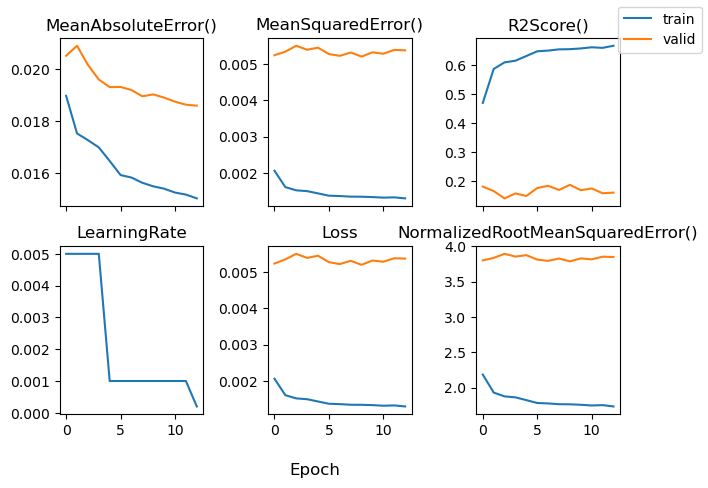

In [21]:
util.plot.plot_all_scalars_in_run(f"logs/{model_name}/history/")

Calculate performance on test set

In [22]:
from tqdm import tqdm
import pandas as pd

test_metrics = util.training.get_regr_metrics()

m.eval()
with torch.no_grad():
    for (X, y) in tqdm(test_loader, leave=False):
        y_hat = m(X)
        for metric in test_metrics:
            metric(y_hat.view(-1), y.view(-1))

for metric in test_metrics:
    print(f"{str(metric)}: {metric.compute():.3f}")

NormalizedRootMeanSquaredError(): 4.071
R2Score(): 0.171
MeanAbsoluteError(): 0.011
MeanSquaredError(): 0.001


What if we test/validate on the smoothed signal?

In [23]:
valid_loader_ewma = DataLoader(
    valid_wds, 
    batch_size, 
    shuffle=True, 
    collate_fn=train_collator, 
    generator=torch.Generator(device=device)
)
test_loader_ewma  = DataLoader(
    test_wds, 
    batch_size, 
    shuffle=True, 
    collate_fn=train_collator, 
    generator=torch.Generator(device=device)
)

In [24]:
test_metrics_ewma = util.training.get_regr_metrics()

m.eval()
with torch.no_grad():
    for (X, y) in tqdm(test_loader_ewma, leave=False):
        y_hat = m(X)
        for metric in test_metrics_ewma:
            metric(y_hat.view(-1), y.view(-1))

for metric in test_metrics_ewma:
    print(f"{str(metric)}: {metric.compute():.3f}")

NormalizedRootMeanSquaredError(): 2.253
R2Score(): 0.519
MeanAbsoluteError(): 0.007
MeanSquaredError(): 0.001


In [25]:
valid_metrics_ewma = util.training.get_regr_metrics()

m.eval()
with torch.no_grad():
    for (X, y) in tqdm(valid_loader_ewma, leave=False):
        y_hat = m(X)
        for metric in valid_metrics_ewma:
            metric(y_hat.view(-1), y.view(-1))

for metric in valid_metrics_ewma:
    print(f"{str(metric)}: {metric.compute():.3f}")

NormalizedRootMeanSquaredError(): 2.687
R2Score(): 0.420
MeanAbsoluteError(): 0.011
MeanSquaredError(): 0.002


In [26]:
train_metrics = util.training.get_final_metrics(f"logs/{model_name}/history")

In [27]:
train_metrics

{'NormalizedRootMeanSquaredError()/train': 1.7350430488586426,
 'R2Score()/train': 0.666188657283783,
 'MeanAbsoluteError()/train': 0.015027621760964394,
 'MeanSquaredError()/train': 0.0012984916102141142,
 'NormalizedRootMeanSquaredError()/valid': 3.848796844482422,
 'R2Score()/valid': 0.16157680749893188,
 'MeanAbsoluteError()/valid': 0.01859283447265625,
 'MeanSquaredError()/valid': 0.00537624629214406,
 'Loss/train': 0.0012987001100555062,
 'Loss/valid': 0.005365555640310049,
 'LearningRate': 0.00019999999494757503}

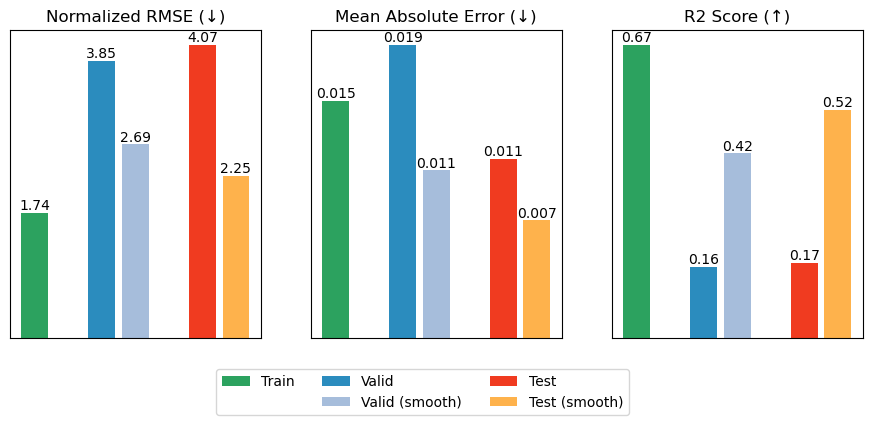

In [28]:
from matplotlib.patches import Rectangle

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 4))

nrmse = "NormalizedRootMeanSquaredError()"
mae = "MeanAbsoluteError()"
r2 = "R2Score()"

label = ["Train", "Valid", "Valid (smooth)", "Test", "Test (smooth)"]
color = ["#2ca25f", "#2b8cbe", "#a6bddb", "#f03b20", "#feb24c"]

nrmse_values = [
    train_metrics[f"{nrmse}/train"],
    train_metrics[f"{nrmse}/valid"], 
    valid_metrics_ewma[0].compute(), 
    test_metrics[0].compute(), 
    test_metrics_ewma[0].compute()
]
r2_values = [
    train_metrics[f"{r2}/train"], 
    train_metrics[f"{r2}/valid"], 
    valid_metrics_ewma[1].compute(), 
    test_metrics[1].compute(), 
    test_metrics_ewma[1].compute()
]
mae_values = [
    train_metrics[f"{mae}/train"], 
    train_metrics[f"{mae}/valid"], 
    valid_metrics_ewma[2].compute(), 
    test_metrics[2].compute(), 
    test_metrics_ewma[2].compute()
]
x = [1, 3, 4, 6, 7]

ax1.set_title("Normalized RMSE (↓)")
b = ax1.bar(x, nrmse_values, label=label, color=color)
ax1.bar_label(b, fmt="%.2f")
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)

ax3.set_title("R2 Score (↑)")
b = ax3.bar(x, r2_values, label=label, color=color)
ax3.bar_label(b, fmt="%.2f")
ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
# ax2.legend()

ax2.set_title("Mean Absolute Error (↓)")
b = ax2.bar(x, mae_values, label=label, color=color)
ax2.bar_label(b, fmt="%.3f")
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
# ax2.legend()

handles, labels = ax1.get_legend_handles_labels()
handles.insert(1, Rectangle((0, 0), 0, 0, visible=False))
labels.insert(1, "")

plt.legend(handles, labels, ncol=3, loc = 'lower center', bbox_to_anchor = (0, -0.1, 1, 1),
           bbox_transform = plt.gcf().transFigure)
# fig.tight_layout()

Prediction map

In [29]:
# Reload the right model
input_channel = len(input_bands)
hidden_dim = 4
num_layers = 2
kernel = (3, 3)
m = DamageConvLSTM(
    input_channel, 
    hidden_dim, 
    kernel, 
    num_layers, 
    batch_first=True,
    dropout=0.3
)

m.load_state_dict(torch.load(f"logs/{model_name}/model.pth", weights_only=True))
m.eval()

DamageConvLSTM(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (drop): Dropout(p=0.3, inplace=False)
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (drop): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (conv): Conv2d(4, 1, kernel_size=(1, 1), stride=(1, 1))
  (sigmoid): Sigmoid()
  (bn): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [30]:
inference_window = dict(x=[8, False], y=[8, False], time=[4, False])
ds_infer = ds.sel(time=np.concatenate([valid_years, test_years]))
wds_infer = util.datasets.WindowXarrayDataset(
    ds_infer, window, 
    mask=ds_infer.sel(band="mortality"), 
    na_thresh=0.5,
    downsample_step=10
)
print(len(wds_infer))

56471


In [31]:
ch_means = m.bn.running_mean

def inference_collator(patch):
    X = torch.tensor(
            np.squeeze(patch.values[:-1, input_inds, :, :]),
            dtype=dtype
        ).unsqueeze(0)

    # Replace nan cells with the channel mean
    X = torch.nan_to_num(X)
    X += m.bn.running_mean * torch.isnan(X)
    return X

In [32]:
out_arr = np.zeros(ds_infer.isel(band=0).shape)
out_n   = np.zeros(out_arr.shape)

with torch.no_grad():
    for i in tqdm(range(len(wds_infer))):
        input_tensor = inference_collator(wds_infer[i])
        t = wds_infer.valid_indices["time"][i]
        y = wds_infer.valid_indices["y"][i]
        x = wds_infer.valid_indices["x"][i]
    
        output_tensor = m(input_tensor).detach().numpy()
        output_tensor = np.log10(output_tensor)
    
        out_arr[t, y-7:y+1, x-7:x+1] += output_tensor[0, ...]
        out_n[t, y-7:y+1, x-7:x+1] += 1

100%|██████████| 56471/56471 [02:34<00:00, 364.99it/s]


In [33]:
out_avg = out_arr / out_n
out_arr[out_n == 0] = np.nan
out_pct = 10 ** out_avg

out_da = xr.DataArray(
    data=out_pct,
    dims=["time", "y", "x"],
    coords=dict(
        time=ds_infer.time,
        y=ds_infer.y,
        x=ds_infer.x
    )
)

/tmp/ipykernel_1617/2143291068.py:1: RuntimeWarning: invalid value encountered in divide
  out_avg = out_arr / out_n


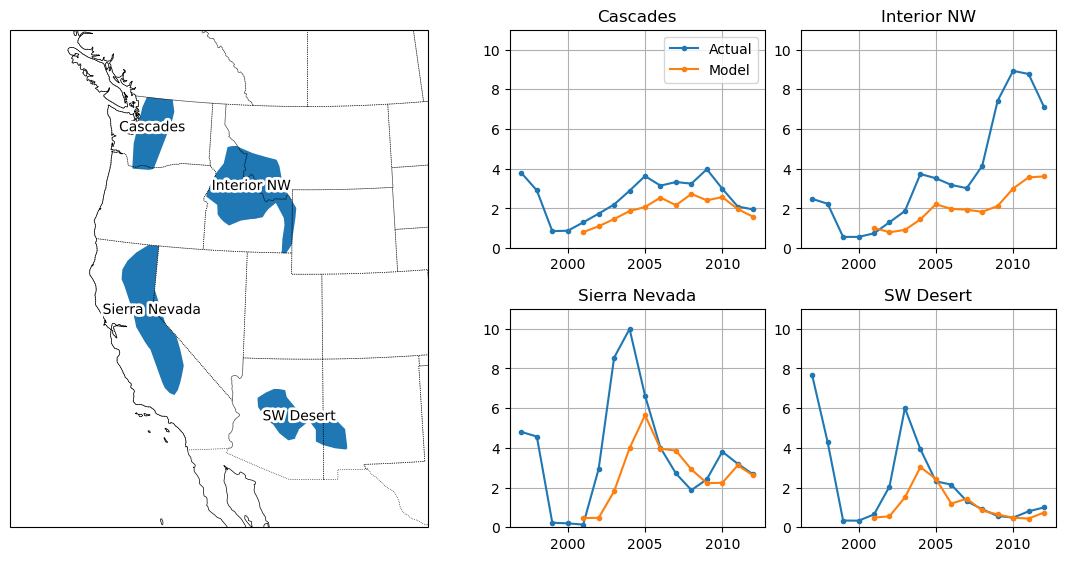

In [34]:
from matplotlib.gridspec import GridSpec
import matplotlib.patheffects as pe
import geopandas as gpd
from cartopy import crs as ccrs
from cartopy import feature as cfeature
import shapely
from shapely.geometry import box

regions = gpd.read_file("data_in/regions_simple2.geojson")

fig = plt.Figure(layout="constrained", figsize=(11, 5.5))
gs = GridSpec(2, 3, figure=fig, width_ratios=[2, 1, 1])

projection = ccrs.AlbersEqualArea(central_latitude=42, central_longitude=-110)
map_ax = fig.add_subplot(gs[:, 0], projection=projection)

# Make the map
map_ax.coastlines(linewidth=0.5)

# Expand the bounding box a little so that we don't crop too much
mycrs = ccrs.epsg("3857")
bbox = box(*regions.total_bounds)
bbox = bbox.buffer(5e5) # meters

minx, miny, maxx, maxy = shapely.bounds(bbox)

# Add region geometries
for i in range(regions.shape[0]):
    geom = regions.geometry[i]
    map_ax.add_geometries(geom, crs=mycrs)
    map_ax.text(
        geom.centroid.x, geom.centroid.y, regions.name[i], 
        transform=mycrs,
        horizontalalignment="center",
        path_effects=[pe.withStroke(linewidth=4, foreground="white")]
    )

map_ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='black', linewidth=0.5)
map_ax.set_extent((minx, maxx, miny, maxy), crs=mycrs)

axes = []

for i, (row, col) in enumerate(zip((1, 0, 1, 0), (2, 1, 1, 2))):
    ax = fig.add_subplot(gs[row, col])
    axes.append(ax)
    geom = regions.geometry[i]
    model = out_da.rio.write_crs(3857).rio.clip([geom]).mean(dim=["x", "y"], skipna=True).values * 100
    data  = ds_infer.sel(band="mort_ewma").rio.write_crs(3857).rio.clip([geom]).mean(dim=["x", "y"], skipna=True).values

    ax.plot(ds_infer.time, data, label="Actual", marker=".")
    ax.plot(ds_infer.time, model, label="Model", marker=".")
    ax.set_ylim(0, 11)
    ax.set_title(regions.name[i])
    ax.grid()

axes[1].legend()

fig